In [337]:
import geopandas as gpd
from sodapy import Socrata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates


from hidden_config import Config

Use API key and credentials to query Socrata database

In [88]:
url = "data.cityofchicago.org"
client = Socrata(url,
                 Config.API_KEY,
                 username=Config.USERNAME,
                 password=Config.PASSWORD)

red_light_violations_uri = 'spqx-js37'
speed_camera_violations_uri = 'hhkd-xvj4'

# defaul limit is 1000
red_light_violations_list = client.get(red_light_violations_uri, limit=1000000)
speed_camera_violations_list = client.get(speed_camera_violations_uri, limit=1000000)

red_light_violations_df = pd.DataFrame(red_light_violations_list)
speed_camera_violations_df = pd.DataFrame(speed_camera_violations_list)


### Data Cleansing
Cast the columns to their proper data types

In [89]:
speed_camera_violations_df['violations'] = speed_camera_violations_df['violations'].astype(float)
red_light_violations_df['violations'] = red_light_violations_df['violations'].astype(float)

speed_camera_violations_df['violation_date'] = pd.to_datetime(speed_camera_violations_df['violation_date'])
red_light_violations_df['violation_date'] = pd.to_datetime(red_light_violations_df['violation_date'])

speed_camera_violations_df['violation_day_of_week'] = speed_camera_violations_df['violation_date'].dt.strftime('%A')
red_light_violations_df['violation_day_of_week'] = pd.to_datetime(red_light_violations_df['violation_date']).dt.strftime('%A')

Drop the metadata columns the database adds

In [90]:
speed_cols_to_drop = speed_camera_violations_df.filter(like='@computed', axis=1)
speed_camera_violations_df.drop(columns=speed_cols_to_drop, axis=1, inplace=True)

red_light_cols_to_drop = red_light_violations_df.filter(like='@computed', axis=1)
red_light_violations_df.drop(columns=red_light_cols_to_drop, axis=1, inplace=True)

### Data Summary


In [91]:
print(f"There are {speed_camera_violations_df['camera_id'].nunique()} speed cameras in the city. They issue {round(speed_camera_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} tickets per day")
print(f"There are {red_light_violations_df['camera_id'].nunique()} red light cameras in the city. They issue {round(red_light_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} tickets per day")

There are 181 speed cameras in the city. They issue 41.1 tickets per day
There are 365 red light cameras in the city. They issue 6.2 tickets per day


Consider the distribution of how many cameras are issuing tickets

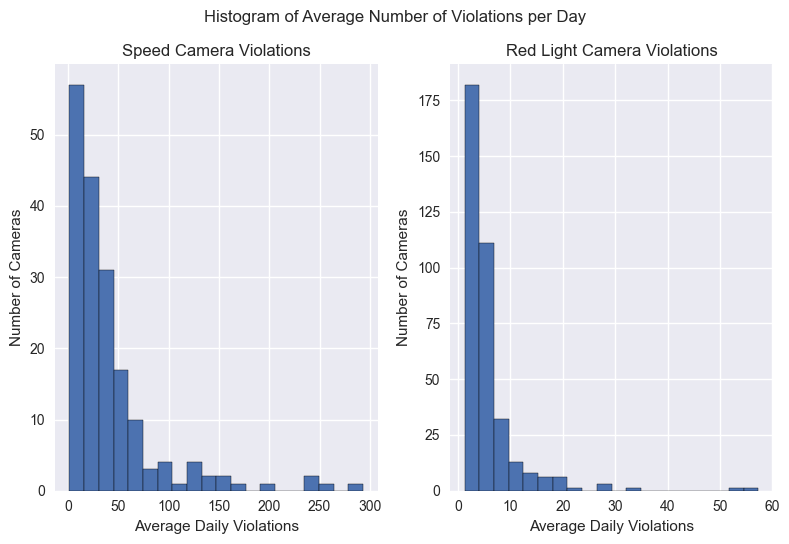

In [92]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

average_speed_violations_per_camera_per_day = speed_camera_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean()
average_red_light_violations_per_camera_per_day = red_light_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean()

ax[0].hist(average_speed_violations_per_camera_per_day, bins=20, edgecolor='black')
ax[1].hist(average_red_light_violations_per_camera_per_day, bins=20, edgecolor='black')

ax[0].set_xlabel('Average Daily Violations')
ax[0].set_ylabel('Number of Cameras')
ax[0].set_title('Speed Camera Violations')

ax[1].set_xlabel('Average Daily Violations')
ax[1].set_ylabel('Number of Cameras')
ax[1].set_title('Red Light Camera Violations')

fig.suptitle('Histogram of Average Number of Violations per Day')
plt.tight_layout()
plt.show()

In [93]:
camera_id_of_highest_frequency = red_light_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean().sort_values().index[-1]
highest_average_frequency = round(red_light_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean().sort_values().values[-1],1)
intersection_of_highest_red_light_violations = red_light_violations_df[red_light_violations_df['camera_id'] == camera_id_of_highest_frequency]['intersection'].unique()[0]

print(f"We can see there is an outlier for the red light camera violations. \
      \nOne camera is averaging {highest_average_frequency} violations per day even though the average for the rest of the dataset is {round(red_light_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} violations per day. \
      \nThis intersection is {intersection_of_highest_red_light_violations}")

We can see there is an outlier for the red light camera violations.       
One camera is averaging 57.4 violations per day even though the average for the rest of the dataset is 6.2 violations per day.       
This intersection is CICERO AND I55


### Temporal Analysis
Let's see how the number of violations trends over time.

Chicago is constantly installing more cameras. We can see how many unique camera_ids are present in each data set per month. This analysis assumes that each camera will have at least 1 violation per month in order to be represented in this analysis.

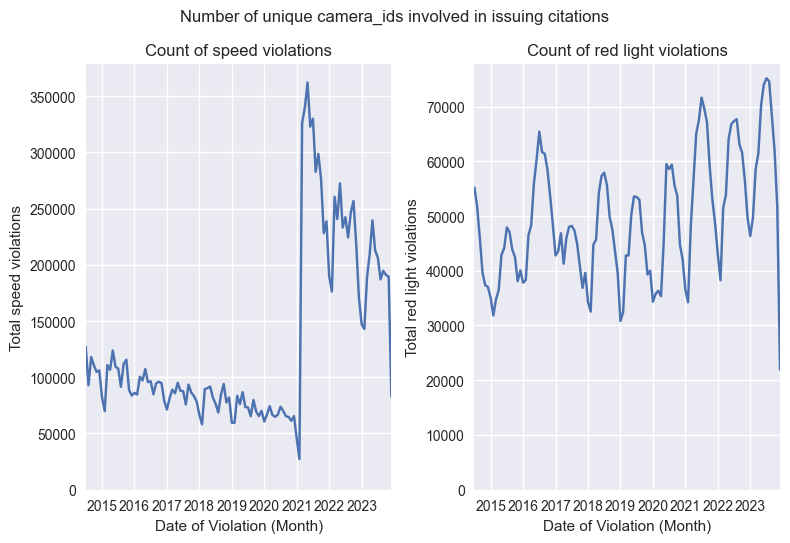

In [141]:
speed_camera_violations_df['violation_month'] = speed_camera_violations_df['violation_date'].dt.to_period('M')
total_speed_camera_violations_per_month = speed_camera_violations_df.groupby('violation_month')['violations'].sum().sort_index()

red_light_violations_df['violation_month'] = red_light_violations_df['violation_date'].dt.to_period('M')
total_red_light_camera_violations_per_month = red_light_violations_df.groupby('violation_month')['violations'].sum().sort_index()

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

total_speed_camera_violations_per_month.plot(kind='line', ax=ax[0])
ax[0].set_title('Count of speed violations')
ax[0].set_xlabel('Date of Violation (Month)')
ax[0].set_ylabel('Total speed violations')
ax[0].set_ylim(0)  # Ensure y-axis starts at 0


total_red_light_camera_violations_per_month.plot(kind='line', ax=ax[1])
ax[1].set_title('Count of red light violations')
ax[1].set_xlabel('Date of Violation (Month)')
ax[1].set_ylabel('Total red light violations')
ax[1].set_ylim(0)  # Ensure y-axis starts at 0

plt.suptitle('Number of unique camera_ids involved in issuing citations')
plt.tight_layout()


Let's note an interesting observations in these charts. We can see that the total count of speed violations appears to dip, then skyrocket in early 2021. The decline was caused by the city's COVID lockdown. The city's push for remote work caused a decline in traffic, which resulted in a reduction of driving violations. However, we can see there is a surge in speed camera violations in 2021. This was due to the city **reducing** the minimum speed required to be cited by a speed camera. Before 2021, the city would only cite drivers going >= 10 mph over the speed limit. However, in March 2021, they introduced another tier of tickets that would be issued to drivers goign 6-10 mph over the speed limit. [source](https://abc7chicago.com/chicago-speed-camera-ticket-cameras-pay-speeding/13255936/)

### Seasonal Analysis
We can see from the charts so far that altough an overall trend may be apparent, there are still peaks and valleys within each time period. These fluctuations *may* be the result of random effects, but they could also be influenced by the **seasonality** factor. Considering the diverse weather conditions experience by Chicagoans throughout the year, it is plausible that driving behaviors vary between winter and summer.


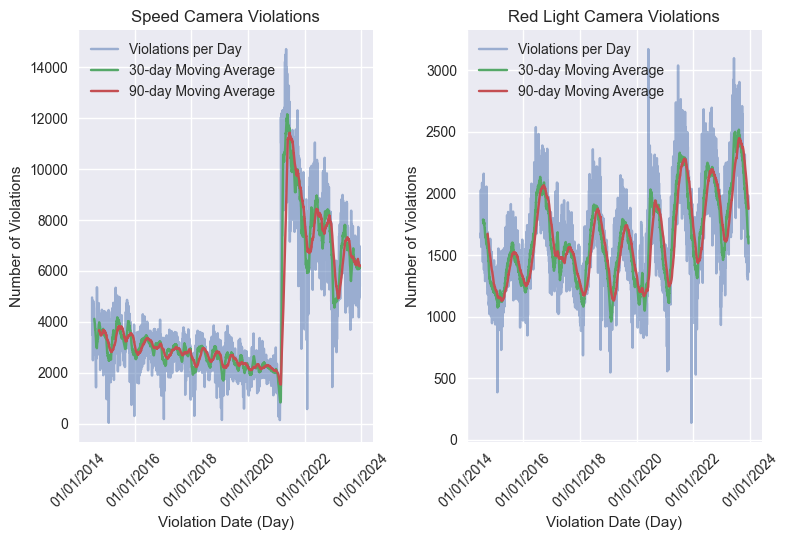

In [159]:
speed_camera_violations_df['30_day_ma'] = speed_camera_violations_df['violations'].rolling(window=30).mean()

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

ax[0].plot(speed_camera_violations_df.groupby('violation_date')['violations'].sum(), label='Violations per Day', alpha=0.5)

speed_camera_daily_sum = pd.DataFrame(speed_camera_violations_df.groupby('violation_date')['violations'].sum())
speed_camera_ma = speed_camera_daily_sum.rolling(window=30).mean()
ax[0].plot(speed_camera_ma['violations'], label='30-day Moving Average')
speed_camera_ma = speed_camera_daily_sum.rolling(window=90).mean()
ax[0].plot(speed_camera_ma['violations'], label='90-day Moving Average')


ax[0].tick_params(axis='x', rotation=45)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax[0].set_xticks(ax[0].get_xticks()[::2])
ax[0].set_xlabel('Violation Date (Day)')
ax[0].set_ylabel('Number of Violations')
ax[0].set_title('Speed Camera Violations')
ax[0].legend()

ax[1].plot(red_light_violations_df.groupby('violation_date')['violations'].sum(), label='Violations per Day', alpha=0.5)

red_light_daily_sum = pd.DataFrame(red_light_violations_df.groupby('violation_date')['violations'].sum())
red_light_ma = red_light_daily_sum.rolling(window=30).mean()
ax[1].plot(red_light_ma['violations'], label='30-day Moving Average')
red_light_ma = red_light_daily_sum.rolling(window=90).mean()
ax[1].plot(red_light_ma['violations'], label='90-day Moving Average')


ax[1].tick_params(axis='x', rotation=45)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax[1].set_xticks(ax[1].get_xticks()[::2])
ax[1].set_xlabel('Violation Date (Day)')
ax[1].set_ylabel('Number of Violations')
ax[1].set_title('Red Light Camera Violations')
ax[1].legend()
plt.tight_layout()
plt.show()



Consider how many violations per month for each year.

In [346]:
speed_camera_violations_df['violation_month_part'] = speed_camera_violations_df['violation_date'].dt.strftime('%B')
speed_camera_violations_df['violation_year_part'] = speed_camera_violations_df['violation_date'].dt.strftime('%Y')

sum_speed_months_by_year = speed_camera_violations_df.groupby(['violation_month_part','violation_year_part'])['violations'].sum()
sum_speed_months_by_year = sum_speed_months_by_year.reset_index()

red_light_violations_df['violation_month_part'] = red_light_violations_df['violation_date'].dt.strftime('%B')
red_light_violations_df['violation_year_part'] = red_light_violations_df['violation_date'].dt.strftime('%Y')

sum_red_light_months_by_year = red_light_violations_df.groupby(['violation_month_part','violation_year_part'])['violations'].sum()
sum_red_light_months_by_year = sum_red_light_months_by_year.reset_index()


In [347]:
months = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
sum_speed_months_by_year['violation_month_part'] = pd.Categorical(sum_speed_months_by_year['violation_month_part'], categories=months, ordered=True)

# Sort the DataFrame by 'violation_month_part'
sum_speed_months_by_year = sum_speed_months_by_year.sort_values('violation_month_part')

sum_red_light_months_by_year['violation_month_part'] = pd.Categorical(sum_red_light_months_by_year['violation_month_part'], categories=months, ordered=True)
sum_red_light_months_by_year = sum_red_light_months_by_year.sort_values('violation_month_part')


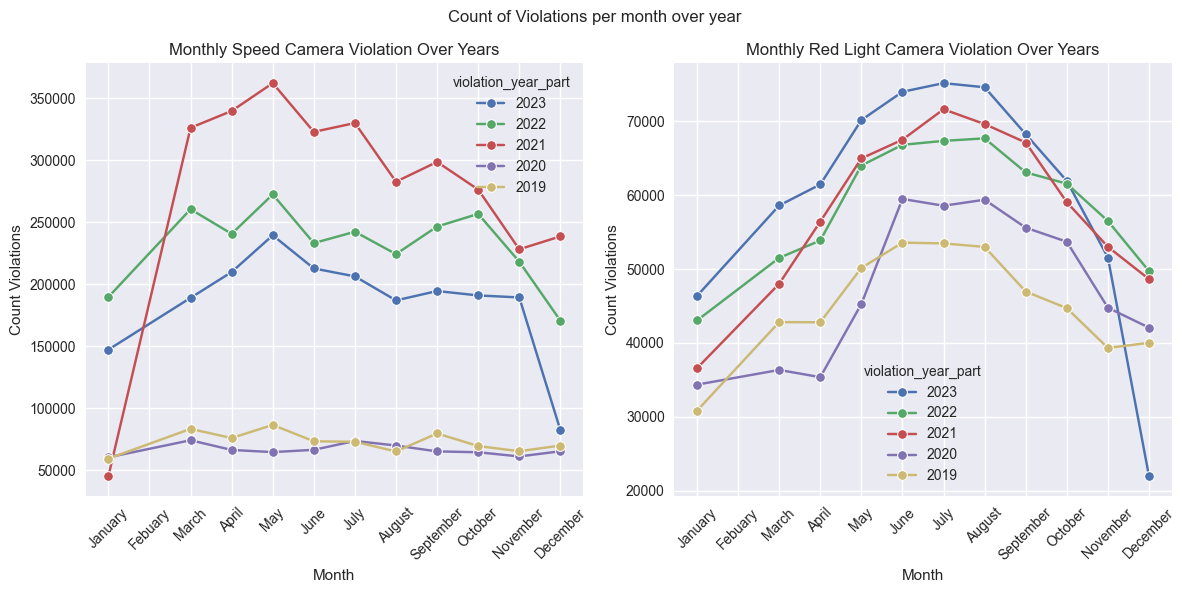

In [354]:
recent_years = np.sort(sum_speed_months_by_year['violation_year_part'].unique())[-5:]

sum_speed_months_by_year_recent = sum_speed_months_by_year[sum_speed_months_by_year['violation_year_part'].isin(recent_years)]
sum_red_light_months_by_year_recent = sum_red_light_months_by_year[sum_red_light_months_by_year['violation_year_part'].isin(recent_years)]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=sum_speed_months_by_year_recent, x='violation_month_part', y='violations', hue='violation_year_part', marker='o', ax=ax[0])

ax[0].set_xlabel('Month')
ax[0].set_ylabel('Count Violations')
ax[0].set_title('Monthly Speed Camera Violation Over Years')
ax[0].tick_params(axis='x', rotation=45)

sns.lineplot(data=sum_red_light_months_by_year_recent, x='violation_month_part', y='violations', hue='violation_year_part', marker='o', ax=ax[1])

ax[1].set_xlabel('Month')
ax[1].set_ylabel('Count Violations')
ax[1].set_title('Monthly Red Light Camera Violation Over Years')
ax[1].tick_params(axis='x', rotation=45)

plt.suptitle('Count of Violations per month over year')
plt.tight_layout()
plt.show()



### DoW Analysis

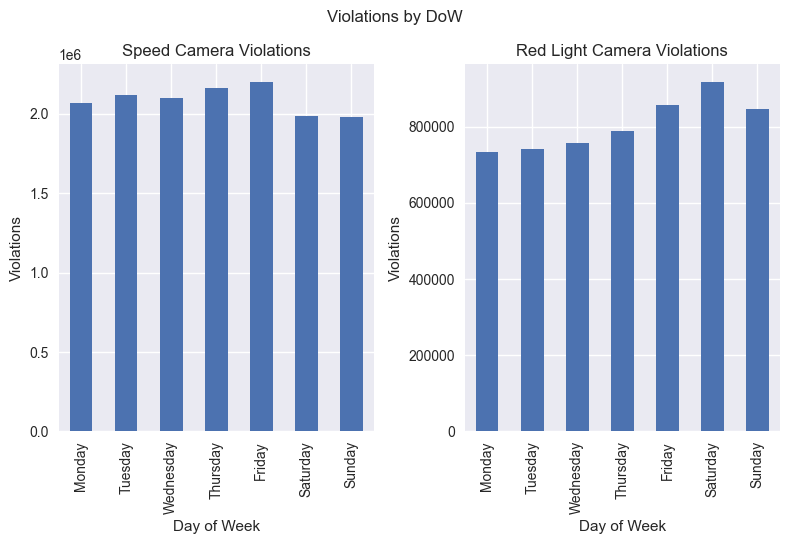

In [116]:
# Sum violations by day of week
speed_camera_violations_by_dow = speed_camera_violations_df.groupby(['violation_day_of_week'])['violations'].sum()

# Do the same for red light cameras
red_light_violations_by_dow = red_light_violations_df.groupby(['violation_day_of_week'])['violations'].sum()

# Create a Categorical data type with the desired order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_order = pd.CategoricalDtype(categories=day_order, ordered=True)

speed_camera_violations_by_dow.index = speed_camera_violations_by_dow.index.astype(cat_order)
red_light_violations_by_dow.index = red_light_violations_by_dow.index.astype(cat_order)

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

speed_camera_violations_by_dow.sort_index().plot(kind='bar', ax=ax[0])
red_light_violations_by_dow.sort_index().plot(kind='bar', ax=ax[1])

ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('Violations')
ax[0].set_title('Speed Camera Violations')

ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Violations')
ax[1].set_title('Red Light Camera Violations')

fig.suptitle('Violations by DoW')
plt.tight_layout()
plt.show()


In [117]:
# Read the GeoJSON data from the boundaries shapefiles. 
chicago_communities = gpd.read_file('chicago_communities')

In [118]:
# Extract the latitude and longitude values from the 'location' column
red_light_violations_df['latitude'] = red_light_violations_df['location'].apply(lambda x: x['latitude'] if isinstance(x, dict) and 'latitude' in x else None)
red_light_violations_df['longitude'] = red_light_violations_df['location'].apply(lambda x: x['longitude'] if isinstance(x, dict) and 'longitude' in x else None)

